In [1]:
from system import System, DynamicSystem
import torch

In [2]:
system = System(wind_limits=[0.0,0.0])
actor = lambda x: torch.tensor([[0.507,0.503]])
critic = lambda x: torch.zeros((1))

In [3]:
dynamics = DynamicSystem(system,actor,critic)

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.
Your vector field does not have `nn.Parameters` to optimize.


In [8]:
state = system.init_state()
state1 = torch.cat([torch.tensor([[1.0,1.00]]),state[:,2:]],dim=1)
state2 = torch.cat([torch.tensor([[1.8,0.9]]),state[:,2:]],dim=1)
state3 = torch.cat([torch.tensor([[4.8,1.2]]),state[:,2:]],dim=1)
new_state = torch.cat([state1,state2,state3],dim=0)

In [12]:
dynamics.make_transition(system.init_state(),torch.tensor([[0.507,0.503]]))

tensor([[ 2.0000e-01,  4.0123e-02,  2.3818e-06,  4.9050e-03, -1.4423e-05,
         -5.7692e-04,  0.0000e+00]], dtype=torch.float64)

In [9]:
system.get_observation(new_state)

tensor([[ 1.2750,  1.2750,  0.0600,  0.2600,  0.0000,  0.0000,  0.0000],
        [ 0.4750,  0.4750,  1.0600,  0.8600,  0.0000,  0.0000,  0.0000],
        [10.0000, 10.0000,  0.7600,  1.1600,  0.0000,  0.0000,  0.0000]],
       dtype=torch.float64)

In [10]:
system.get_reward(new_state,torch.tensor([[0.5,0.5],[0.5,0.5],[0.5,0.5]]))

tensor([-6.8988e+00, -3.3640e+00, -4.0000e-03], dtype=torch.float64)

In [5]:
new_state

tensor([[1.0000, 0.9000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.8000, 0.9000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [4.7000, 1.2000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
       dtype=torch.float64)

In [6]:
dynamics.system.get_observation(new_state)

tensor([[ 1.2750,  1.2750,  0.2000,  0.2000,  0.0000,  0.0000],
        [ 0.4750,  0.4750,  1.1000,  0.9000,  0.0000,  0.0000],
        [10.0000, 10.0000,  0.8000,  1.2000,  0.0000,  0.0000]],
       dtype=torch.float64)

In [4]:
dynamics.calc_total_reward()

tensor([-1570.4464], dtype=torch.float64)

In [5]:
dynamics.actor_loss(dynamics.init_state()), dynamics.critic_loss(dynamics.init_state())

(tensor([23.1000], dtype=torch.float64), tensor(533.6100, dtype=torch.float64))

In [4]:
dynamics.visualize_episode()

In [5]:
dynamics.init_state().shape

torch.Size([1, 7])

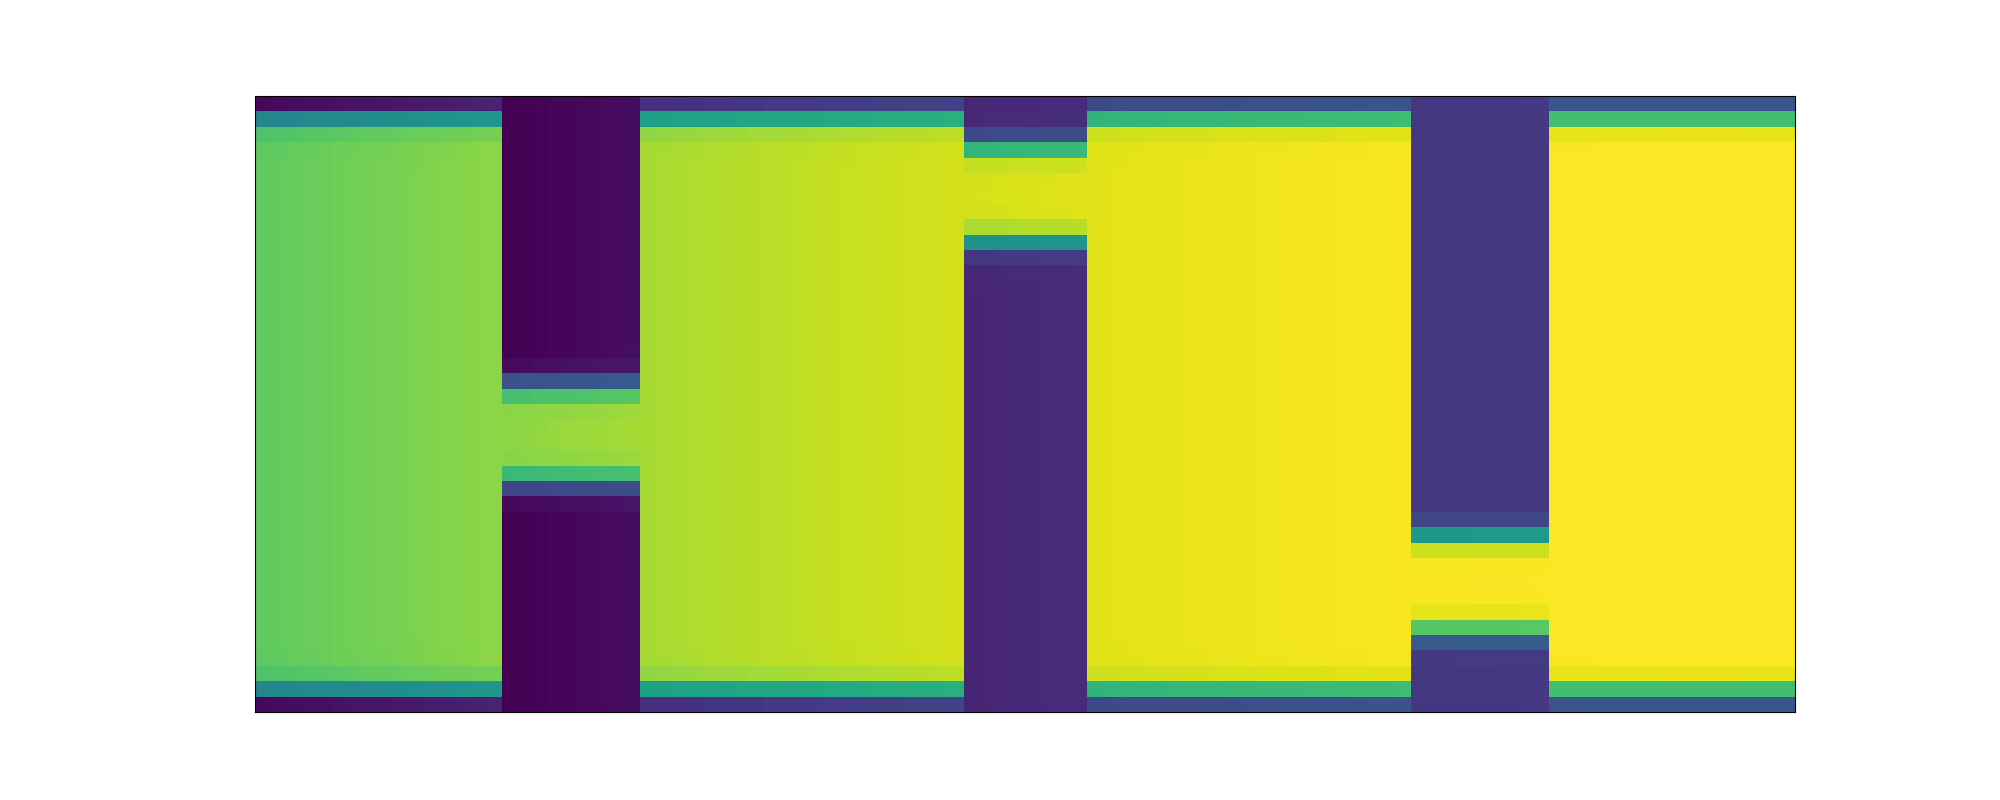

In [4]:
system.visualize_reward(dynamics.init_state(),actor(dynamics.get_observation(dynamics.init_state())))

## Actor-Critic Learning

In [1]:
import torch
import IPython.display as ipd

from system import System, DynamicSystem
from actor_critic import Actor, Critic, ActorCriticTrainer

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
torch.manual_seed(42)

system = System(wind_limits=[0.0,0.0], device=device)
actor = Actor(dim=64, depth=3).double().to(device)
critic = Critic(dim=64, depth=3, scale=2500.).double().to(device)

dynamics = DynamicSystem(system,actor,critic, device=device)
actor, critic

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.
Your vector field does not have `nn.Parameters` to optimize.


(Actor(
   (net): Sequential(
     (0): Linear(in_features=7, out_features=64, bias=True)
     (1): LeakyReLU(negative_slope=0.01)
     (2): Linear(in_features=64, out_features=64, bias=True)
     (3): LeakyReLU(negative_slope=0.01)
     (4): Linear(in_features=64, out_features=2, bias=True)
     (5): Sigmoid()
   )
 ),
 Critic(
   (net): Sequential(
     (0): Linear(in_features=7, out_features=64, bias=True)
     (1): LeakyReLU(negative_slope=0.01)
     (2): Linear(in_features=64, out_features=64, bias=True)
     (3): LeakyReLU(negative_slope=0.01)
     (4): Linear(in_features=64, out_features=1, bias=True)
     (5): Tanh()
     (6): Scale(factor=2500.0)
   )
 ))

In [3]:
trainer = ActorCriticTrainer(dynamics=dynamics)
trainer.init_optimizers(
    actor_optimizer=torch.optim.Adam(actor.parameters(), lr=1e-4),
    critic_optimizer=torch.optim.Adam(critic.parameters(), lr=5e-5)
)

In [4]:
training_history = trainer.run(
    iterations=30,
    critic_subiters=20,
    actor_subiters=1,
    critic_batch_size=1000,
    actor_batch_size=4000,
    grad_clip_norm=1e0,
    verbose=True
)
training_history

TypeError: unsupported operand type(s) for +: 'int' and 'tuple'

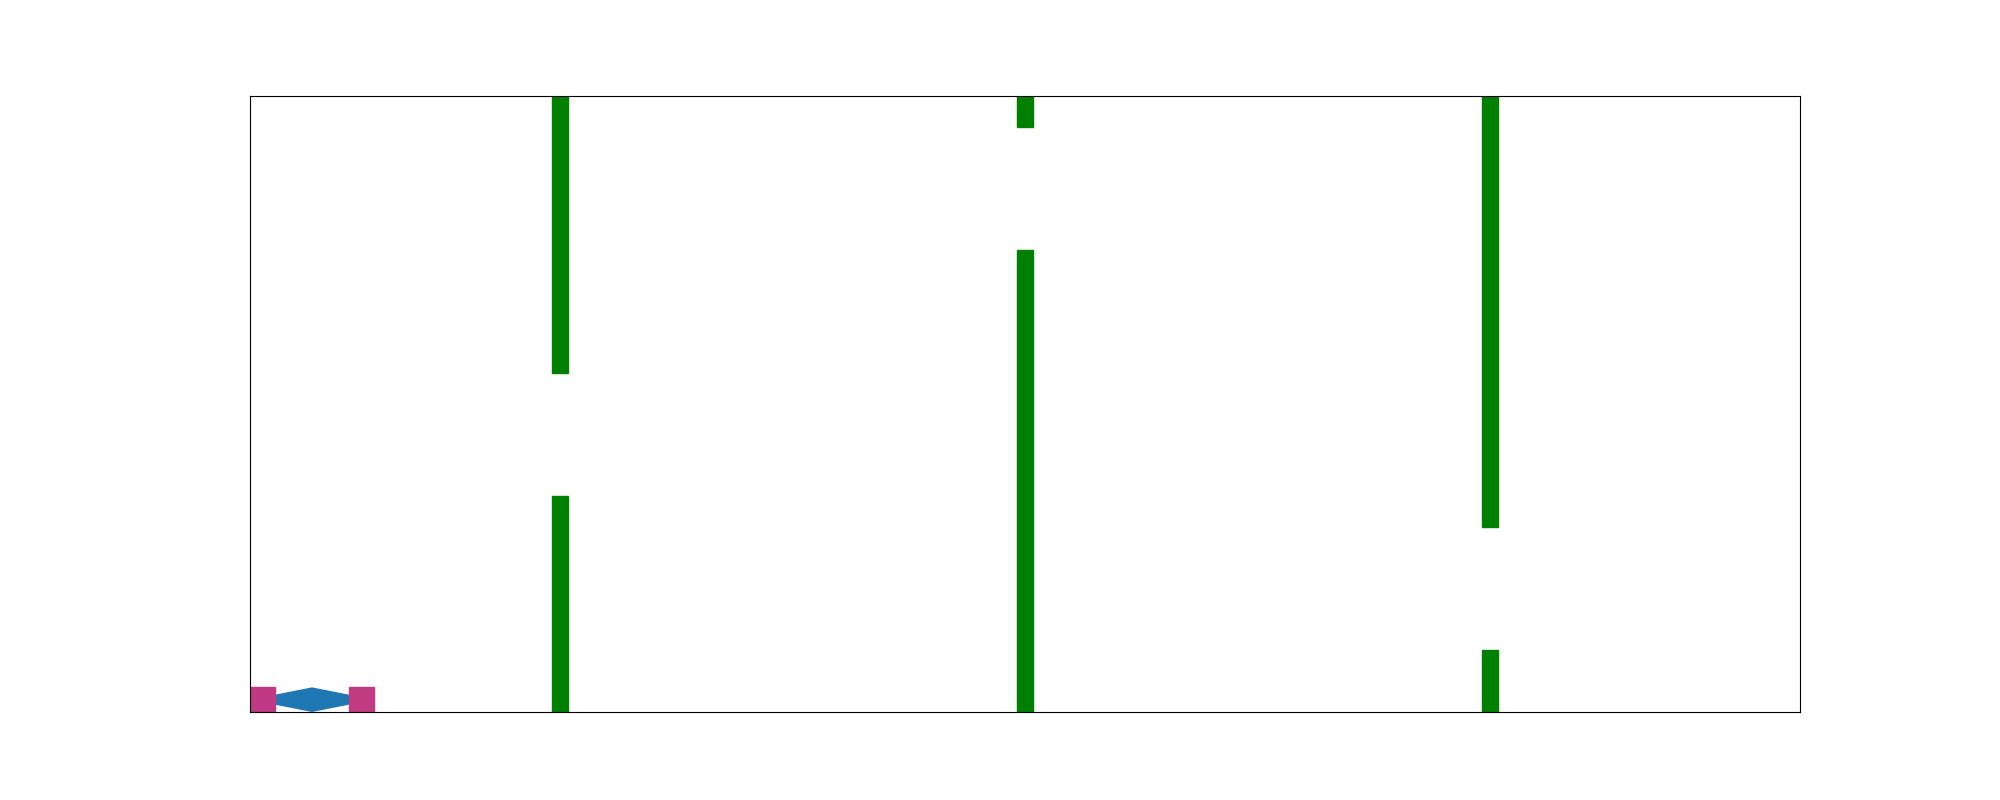

In [5]:
gif_path = 'episode_ac-n3d64_it10.gif'
dynamics.visualize_episode(save_path=gif_path)
ipd.display(ipd.Image(data=open(gif_path,'rb').read(), format='png'))

In [ ]:
# continue training
training_history = trainer.run(
    iterations=1000,
    episodes=1,
    grad_clip_norm=1e4,
    verbose=True
)